In [28]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.io import ascii

In [29]:
def deg_to_sex(ra, dec):
    c = SkyCoord(ra = ra*u.degree, dec = dec*u.degree)
    print('RA: {0}\ndec: {1}'.format(c.ra.hms, c.dec.dms))

In [30]:
image1 = 'data/PAL5/PAL5/PAL5_3p6um.fits'
#image1 = 'data/PAL5/PAL5__e1/PAL5__e1_3p6um.fits'
image2 = 'data/PAL5/PAL5__e2/PAL5__e2_3p6um.fits'
with fits.open(image1) as hdul:
    hdr1 = hdul[0].header
with fits.open(image2) as hdul:
    hdr2 = hdul[0].header

file1 = 'outputs/table_3p6um_master.txt'
#file1 = 'outputs/table_3p6um_e1.txt'
file2 = 'outputs/table_3p6um_e2.txt'
stars1 = ascii.read(file1, delimiter=',')
stars2 = ascii.read(file2, delimiter=',')

x1 = stars1['xcentroid']
y1 = stars1['ycentroid']
#x1 = stars1['xcenter']
#y1 = stars1['ycenter']
x2 = stars2['xcenter']
y2 = stars2['ycenter']
crd1 = np.transpose((x1, y1))
crd2 = np.transpose((x2, y2))

In [31]:
w1 = wcs.WCS(hdr1)
w2 = wcs.WCS(hdr2)
world1 = w1.wcs_pix2world(crd1, 0)
world2 = w2.wcs_pix2world(crd2, 0)

ra1 = world1[:,0]
dec1 = world1[:,1]
ra2 = world2[:,0]
dec2 = world2[:,1]

c1 = SkyCoord(ra1, dec1, frame='icrs', unit='deg')
c2 = SkyCoord(ra2, dec2, frame='icrs', unit='deg')

idx, d2d, d3d = c2.match_to_catalog_sky(c1)
#print(d3d)

stars1['ra'] = ra1
stars1['dec'] = dec1
stars2['ra'] = ra2
stars2['dec'] = dec2

This method selects stars which are *further* than a certain separation, replaces their indices with -99, and removes them from the dataset:

In [32]:
#radius = 0.25 * u.arcsec
#selection = (d2d > radius)
#match_index = idx
#match_index[selection] = -99.
#ind = ((match_index >= 0))  # removes -99 indices
#print('Number of common stars:', sum(ind))

#mag1 = stars1['apparent_mag'][match_index][ind]
#mag2 = stars2['apparent_mag'][ind]
#delta_mag = stars1['apparent_mag'][match_index][ind] - stars2['apparent_mag'][ind]

This method selects stars which are *closer* than a certain separation, and keeps only those stars in the catalogues (doesn't apply to tables where we have the magnitudes tho):

In [33]:
#radius = 0.25 * u.arcsec
#selection = d2d < radius
#c2_matches = c2[selection]
#c1_matches = c1[idx[selection]]

#print(c2_matches)

USE THIS ONE PLS: This method selects stars which are *further* than a certain separation, replaces their indices with -99, and removes them from the dataset:

In [34]:
radius = 0.25 * u.arcsec
selection = (d2d > radius)
match_index = idx
match_index[selection] = -99.
ind = ((match_index >= 0))  # keeps only positive indices (ie. yeets -99s)
print('Number of common stars:', sum(ind))

newstars1 = stars1[match_index][ind]
newstars2 = stars2[ind]
#delta_mag = newstars1['apparent_mag'] - newstars2['apparent_mag']
print(newstars1)
print(newstars2)
#print(delta_mag)

Number of common stars: 446
id_master     xcentroid      ...         dec                  ra        
--------- ------------------ ... -------------------- ------------------
        1 1269.5063258483376 ... -0.15644268282020193  229.0630315162843
        2 1140.2739672278392 ...  -0.1351476171842811  229.0662732722692
        3 1302.5323577023107 ...  -0.1618256156510142 229.06184132896902
        4   799.686317494766 ...  -0.0788740231578068 229.07389270435505
        6 1152.0517082774918 ...  -0.1367532412693178 229.06392773476134
        7  598.6735177125719 ...  -0.0457152943064213  229.0787177354827
       10 1344.9425064804868 ...  -0.1683672050048424  229.0580442428365
       11 1129.5421224473064 ... -0.13288009487872435 229.06348921167694
       13 1134.6013478827433 ...  -0.1336606723589888 229.06303754176184
       12  655.6895914558028 ... -0.05490643966128278 229.07603925177105
      ...                ... ...                  ...                ...
      745 109.806935517

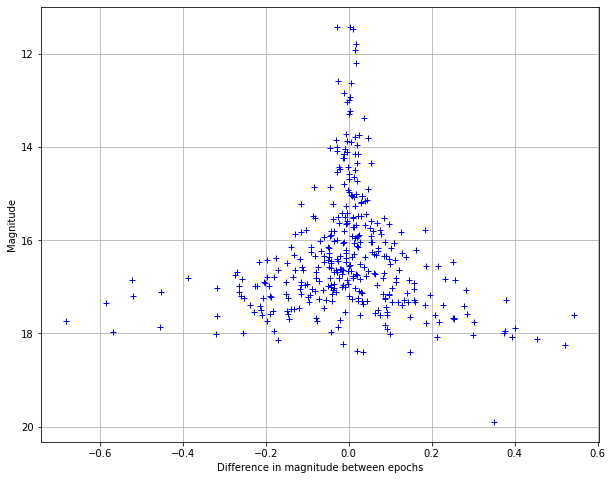

In [21]:
plt.plot(delta_mag, stars1['apparent_mag'], 'b+')
#plt.plot(delta_mag, mag1, 'b+')
plt.xlabel('Difference in magnitude between epochs')
plt.ylabel('Magnitude')
plt.grid()
plt.gca().invert_yaxis()
plt.gcf().set_size_inches(10, 8)
plt.show()

In [88]:
def make_catalog(file, header):
    stars = ascii.read(file, delimiter=',')
    x = stars['xcenter']
    y = stars['ycenter']
    crd = np.transpose((x, y))
    w = wcs.WCS(header)
    world = w.wcs_pix2world(crd, 0)
    ra = world[:,0]
    dec = world[:,1]
    cat = SkyCoord(ra, dec, frame='icrs', unit='deg')
    
    return stars, cat

Ignore this (I didn't finish it, working implementation in main code):

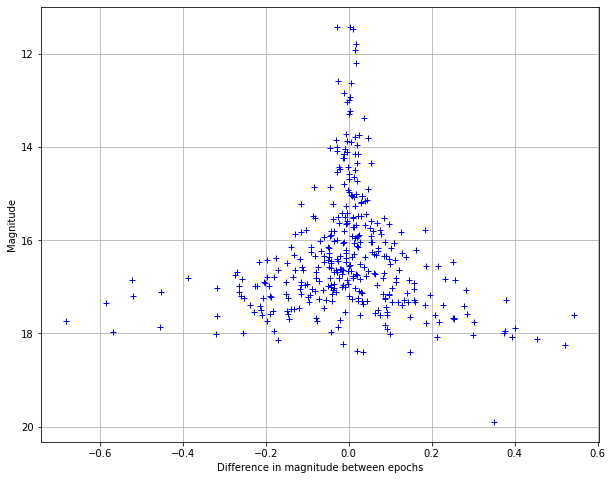

In [67]:
base_dir = 'data/PAL5/'
channel = '3p6um'
#channel = '4p5um'
epoch = 1
n_epoch = 12

comp_epoch = 1
image_comp = base_dir+'PAL5__e'+str(comp_epoch)+'/PAL5__e'+str(comp_epoch)+'_'+channel+'.fits'
with fits.open(image_comp) as hdu_list:
    hdr_comp = hdu_list[0].header
file_comp = 'outputs/table_e'+str(comp_epoch)+'_'+channel+'.txt'

stars_comp, cat_comp = make_catalog(file_comp, hdr_comp)

for i in range(n_epoch):
    
    image_curr = base_dir+'PAL5__e'+str(epoch)+'/PAL5__e'+str(epoch)+'_'+channel+'.fits'
    with fits.open(filename) as hdu_list:
        hdr_curr = hdu_list[0].header
    file_curr = 'outputs/table_e1_3p6um.txt'
    
    stars_curr, cat_curr = make_catalog(file_curr, hdr_curr)
    
    stars1 = ascii.read(file1, delimiter=',')
    stars2 = ascii.read(file2, delimiter=',')

    x1 = stars1['xcenter']
    y1 = stars1['ycenter']
    x2 = stars2['xcenter']
    y2 = stars2['ycenter']
    crd1 = np.transpose((x1, y1))
    crd2 = np.transpose((x2, y2))

    w1 = wcs.WCS(hdr1)
    w2 = wcs.WCS(hdr2)
    world1 = w1.wcs_pix2world(crd1, 0)
    world2 = w2.wcs_pix2world(crd2, 0)

    ra1 = world1[:,0]
    dec1 = world1[:,1]
    ra2 = world2[:,0]
    dec2 = world2[:,1]

    c1 = SkyCoord(ra1, dec1, frame='icrs', unit='deg')
    c2 = SkyCoord(ra2, dec2, frame='icrs', unit='deg')

    idx, d2d, d3d = c2.match_to_catalog_sky(c1)
    #print(d3d)

    stars1['ra'] = ra1
    stars1['dec'] = dec1
    stars2['ra'] = ra2
    stars2['dec'] = dec2

    radius = 0.25 * u.arcsec
    selection = (d2d > radius)
    match_index = idx
    match_index[selection] = -99.
    ind = ((match_index >= 0))  # removes -99 indices
    print('Number of common stars:', sum(ind))

    mag1 = stars1['apparent_mag'][match_index][ind]
    mag2 = stars2['apparent_mag'][ind]
    delta_mag = stars1['apparent_mag'][match_index][ind] - stars2['apparent_mag'][ind]

    plt.plot(delta_mag, mag1, 'b+')
    plt.xlabel('Difference in magnitude between epochs')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.gca().invert_yaxis()
    plt.gcf().set_size_inches(10, 8)
    plt.show()
    
    epoch += 1

In [71]:
print(mag1)
print(mag2)

   apparent_mag   
------------------
17.185296063688693
16.847198276163923
               nan
 15.13531836947663
14.091034930137218
 15.16861460739176
16.141106978649987
16.173555387237784
14.235342159861155
 17.39454099483277
               ...
 17.61055969973998
15.787246715255343
16.355641197764616
 17.10503044244094
 17.27643826575515
 13.80627497415042
 16.68529194607734
 18.07337170594186
17.627372821486667
14.893671082570153
16.637044716521036
Length = 369 rows
   apparent_mag   
------------------
17.704699887287685
 17.36859488533921
               nan
  15.0910228273673
14.118227968106197
 15.12911062754583
 16.11960262767009
16.103666492321786
14.247395813676503
  17.1671190651639
               ...
17.068261978611698
15.890574155107672
 16.31606360129009
17.557229283945887
16.895953646955107
13.759259108333321
16.955310539924955
 17.68057331535602
17.944658393100564
14.847951357850093
16.666874423016704
Length = 369 rows
